In [1]:
import sys
from pathlib import Path

import numpy as np
from joblib import Parallel, delayed
from tqdm import tqdm
from importlib import reload

from matplotlib import pyplot as plt
from seaborn import heatmap, color_palette

# Datasets loading

Lots of different on availabale : https://towardsdatascience.com/a-data-lakes-worth-of-audio-datasets-b45b88cd4ad

Review: 
https://arxiv.org/abs/2012.02974


## Prediction ahead

Datasets available :

* ReservoirPy: MackeyGlass, Lorenz
* Custom: Sunspot

## Classification

Datasets available :

* Custom :  FSDD, HAART, JapaneseVowels
* Aeon : SpokenArabicDigits, CatsDogs, LSST
* Torchaudio: SPEECHCOMMANDS

More on https://www.timeseriesclassification.com/dataset.php or https://pytorch.org/audio/stable/datasets.html

Number of audio files: 3000
Mean sampling rate: 8000.0


2024-11-27 23:07:45.090351: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


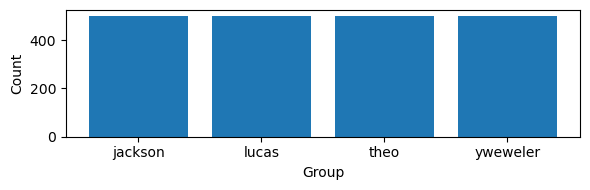

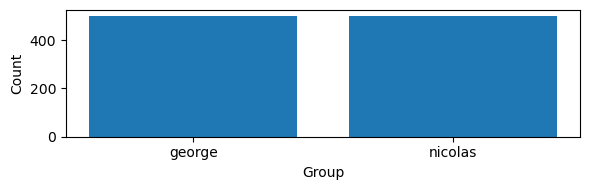

In [2]:
from datasets.load_classification import load_dataset_classification
is_instances_classification = True
spectral_representation = "mfcc"  # Can be None, "stft" or "mfcc"

dataset_name = "FSDD"

use_spectral_representation, is_multivariate, sampling_rate, X_train_raw, X_test_raw, Y_train_raw, Y_test, groups = load_dataset_classification(dataset_name)


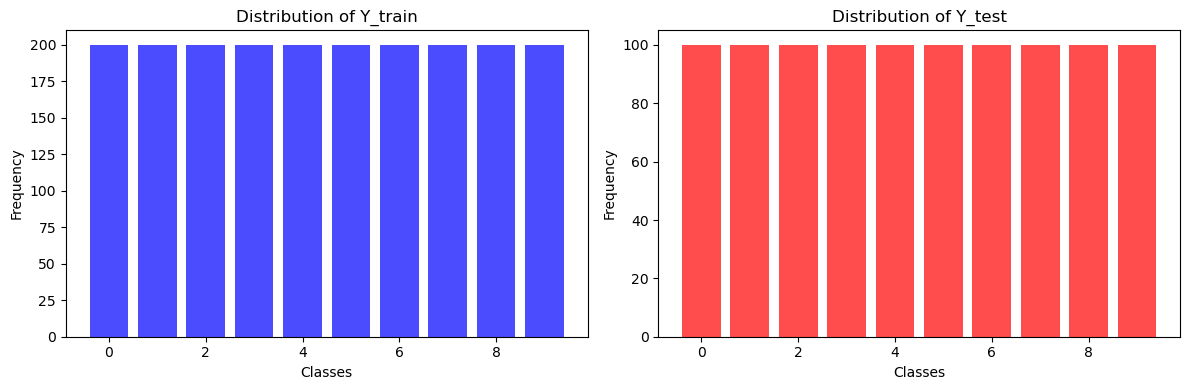

In [3]:
from datasets.preprocessing import plot_classes_distribution

# Plot data distribution
if is_instances_classification:
    plot_classes_distribution(Y_train_raw, Y_test, val = False)


# Cross validation

In [4]:
from sklearn.model_selection import StratifiedKFold, TimeSeriesSplit, StratifiedGroupKFold
from datasets.preprocessing import flexible_indexing, plot_classes_distribution

# CROSS-VALIDATION METHODS
# SEED
SEED = 49387

use_cross_validation = False

n_splits=2

if use_cross_validation: # we split train between train and val
    if is_instances_classification:
        if groups is None:
            splits = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED).split(X_train_raw, np.argmax(Y_train_raw, axis=1))
        else:
            splits = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=SEED).split(X_train_raw, np.argmax(Y_train_raw, axis=1), groups)
    else: #prediction
        splits = TimeSeriesSplit(n_splits=n_splits).split(X_train_raw)
    
    for i, (train_index, val_index) in enumerate(splits):
        X_train = flexible_indexing(X_train_raw, train_index)
        X_val = flexible_indexing(X_train_raw, val_index)
        Y_train = flexible_indexing(Y_train_raw, train_index)
        Y_val = flexible_indexing(Y_train_raw, val_index)
        # SPLITS
        if is_multivariate:
            X_train_band, X_val_band, X_test_band = X_train, X_val, X_test_raw
            del X_train, X_val
        else:
            X_test = X_test_raw

    if is_instances_classification:
        plot_classes_distribution(Y_train, Y_val, val = True)
else: # then we use the test dataset
    if is_multivariate:
        X_train_band, X_test_band = X_train_raw, X_test_raw
        X_val_band = None
    else:
        X_test, X_train = X_test_raw, X_train_raw
        X_val, X_val_band = None, None
    Y_train = Y_train_raw
#del Y_train_raw, X_train_raw, X_test_raw

# Preprocessing

Spectrograms_vs_Cochleagrams : https://www.researchgate.net/publication/340510607_Speech_recognition_using_very_deep_neural_networks_Spectrograms_vs_Cochleagrams

## Multivariate generation (if not multivariate) and train_validation split

Frequency limit:  4000.0 (Shannon sampling theorem)


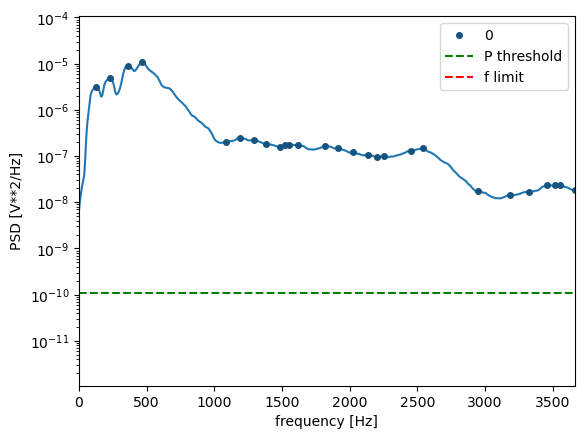

Smoothed peaks:  27
Frequency limit:  4000.0 (Shannon sampling theorem)


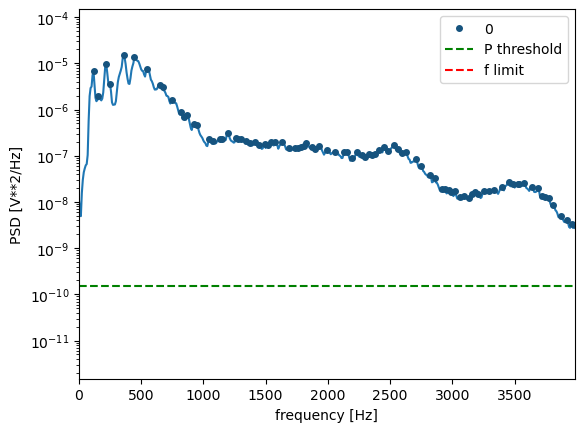

Non-smoothed peaks:  93


In [5]:
from datasets.multivariate_generation import generate_multivariate_dataset, extract_peak_frequencies

freq_train_data = X_train_band if is_multivariate else X_train
flat_train_data = np.concatenate(freq_train_data, axis=0) if is_instances_classification else freq_train_data

WINDOW_LENGTH = 10

smoothed_peaks_freqs = extract_peak_frequencies(flat_train_data, sampling_rate, smooth=True, window_length=WINDOW_LENGTH, threshold=1e-5, nperseg=1024, visualize=True)
nb_smoothed = len(smoothed_peaks_freqs[0]) if is_multivariate else len(smoothed_peaks_freqs)
print("Smoothed peaks: ", nb_smoothed)

peak_freqs = extract_peak_frequencies(flat_train_data, sampling_rate, smooth=True, window_length=1, threshold=1e-5, nperseg=1024, visualize=True)
nb_peaks = len(peak_freqs[0]) if is_multivariate else len(peak_freqs)
print("Non-smoothed peaks: ", nb_peaks)

In [6]:
from datasets.multivariate_generation import generate_multivariate_dataset, extract_peak_frequencies

# if it has use_spectral_representation, then it is multivariate
if use_spectral_representation == True: 
    if is_multivariate==False:
        raise ValueError("Cannot use spectral representation if it's not multivariate !")

if not is_multivariate:
    print(f"Converting single variate to {spectral_representation}")
    X_train_band = generate_multivariate_dataset(
        X_train, sampling_rate, is_instances_classification, peak_freqs, spectral_representation, hop=100
    )
    if use_cross_validation:
        X_val_band = generate_multivariate_dataset(
            X_val, sampling_rate, is_instances_classification, peak_freqs, spectral_representation, hop=100
        )
    X_test_band = generate_multivariate_dataset(
            X_test, sampling_rate, is_instances_classification, peak_freqs, spectral_representation, hop=100
    )
        
elif is_multivariate and not use_spectral_representation:
    print(f"Converting multivariate to {spectral_representation}") # if None we convert to temporal
    X_train_band = generate_multivariate_dataset(
        X_train_band, sampling_rate, is_instances_classification, peak_freqs, spectral_representation, hop=100
    )
    if use_cross_validation:
        X_val_band = generate_multivariate_dataset(
            X_val_band, sampling_rate, is_instances_classification, peak_freqs, spectral_representation, hop=100
        )
    X_test_band = generate_multivariate_dataset(
        X_test_band, sampling_rate, is_instances_classification, peak_freqs, spectral_representation, hop=100
    )
else:
    print("Data is already spectral, nothing to do")

if spectral_representation is not None:
    use_spectral_representation = True

Converting single variate to mfcc


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
/opt/homebrew/Caskroom/miniforge/base/envs/hadsp_env/lib/python3.11/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.3s
/opt/homebrew/Caskroom/miniforge/base/envs/hadsp_env/lib/python3.11/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/hadsp_env/lib/python3.11/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Som

## Standardizing the amplitudes

In [7]:
from sklearn.preprocessing import MinMaxScaler
from datasets.preprocessing import scale_data

X_train_band_not_scale = X_train_band
scaler_multi = MinMaxScaler(feature_range=(0, 1))
X_train_band, X_val_band, X_test_band = scale_data(X_train_band, X_val_band, X_test_band, scaler_multi, is_instances_classification)
            
if not is_multivariate:
    X_train_not_scale = X_train
    scaler_x_uni = MinMaxScaler(feature_range=(0, 1))
    X_train, X_val, X_test = scale_data(X_train, X_val, X_test, scaler_multi, is_instances_classification)       


## Visualisation checks

test if the filtering happened correctly

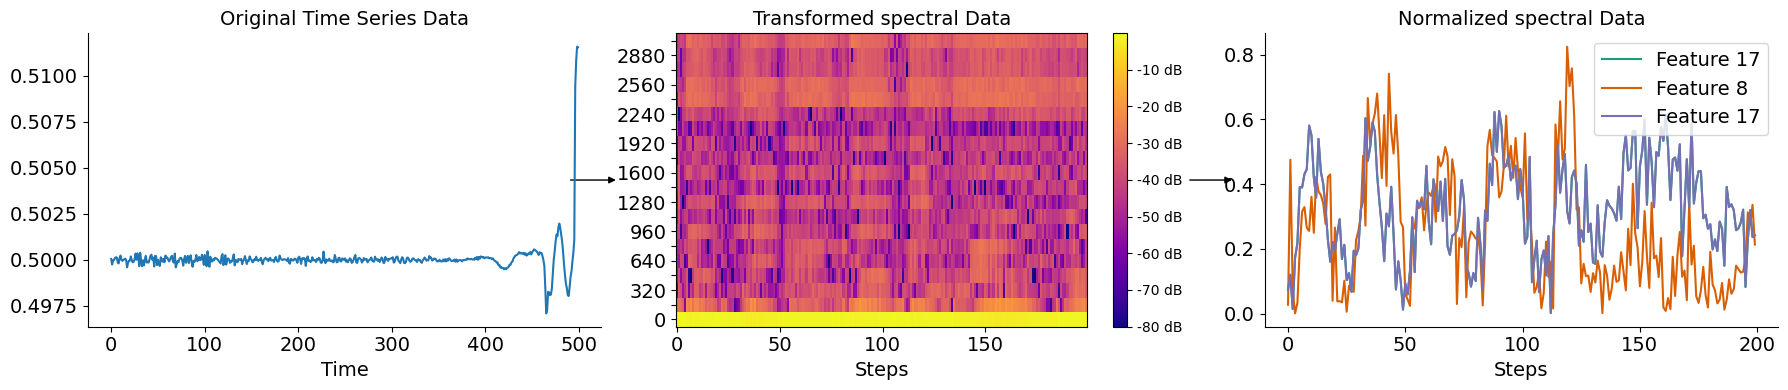

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from seaborn import color_palette
import librosa
import librosa.display
from matplotlib.patches import ConnectionPatch

# Define different color palettes for each step
colors_step1 = color_palette("tab20")    # For the first plot
colors_step2 = color_palette("Set2")     # For the second plot
colors_step3 = color_palette("Dark2")     # For the third plot
fontsize = 14

# Create a figure with three subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))

# First Plot: Original Time Series
if is_instances_classification:
    train_data = np.concatenate(X_train, axis=0).T
else:
    train_data = X_train_raw.T

START = 0
END = 500
DIFF = END - START

ax = axes[0]
for idx, i in enumerate(range(train_data.shape[0])):
    ax.plot(range(DIFF), train_data[i, START:END], color=colors_step1[idx % len(colors_step1)])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', labelsize=fontsize)
ax.set_xlabel('Time', fontsize=fontsize)
#ax.set_ylabel('Value', fontsize=fontsize)
ax.set_title('Original Time Series Data', fontsize=fontsize)

# Second Plot: Transformed Data
if is_instances_classification:
    train_band_data = np.concatenate(X_train_band_not_scale, axis=0).T
else:
    train_band_data = X_train_band_not_scale.T
    
ax = axes[1]
win_length = 50
freqs = librosa.fft_frequencies(sr=sampling_rate, n_fft=win_length)

if use_spectral_representation:
    END = 200
    DIFF = END - START
    S_db = librosa.amplitude_to_db(train_band_data, ref=np.max)[:,START:END]

    # Plot the spectrogram using imshow for manual control
    img = ax.imshow(
        S_db,
        aspect='auto',
        origin='lower',
        interpolation='none',
        cmap='plasma'
    )
    
    # Adjust the yticks to show one out of every two labels
    num_freq_bins = S_db.shape[0]
    ytick_labels = [f"{int(freqs[i])}" if i % 2 == 0 else "" for i in range(num_freq_bins)]
    ax.set_yticks(np.arange(num_freq_bins))  # Keep all the ticks
    ax.set_yticklabels(ytick_labels, fontsize=fontsize)  # Set custom labels
    ax.tick_params(axis='both', labelsize=fontsize)

    ax.set_xlabel('Steps', fontsize=fontsize)
    ax.set_title('Transformed spectral Data', fontsize=fontsize)
    fig.colorbar(img, ax=ax, format="%+2.0f dB")
else:
    random_indexes = np.random.randint(0, train_band_data.shape[0], size=3)
    for idx, i in enumerate(random_indexes):
        ax.plot(range(DIFF), train_band_data[i, START:END],
                color=colors_step2[idx % len(colors_step2)], label=f'Feature {i}')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', labelsize=fontsize)
    ax.set_xlabel('Time', fontsize=fontsize)
    ax.set_title('Transformed spectral Data', fontsize=fontsize)
    ax.legend(fontsize=fontsize, loc='upper right')

# Third Plot: Normalized Data
if is_instances_classification:
    train_band_data = np.concatenate(X_train_band, axis=0).T
else:
    train_band_data = X_train_band.T
ax = axes[2]
if 'random_indexes' not in locals():
    random_indexes = np.random.randint(0, train_band_data.shape[0], size=3)
    
for idx, i in enumerate(random_indexes):
    ax.plot(range(DIFF), train_band_data[i, START:END], color=colors_step3[idx % len(colors_step3)],
            label=f'Feature {i}')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', labelsize=fontsize)
ax.set_xlabel('Steps', fontsize=fontsize)
#ax.set_ylabel('Normalized Value', fontsize=fontsize)
ax.set_title('Normalized spectral Data', fontsize=fontsize)
ax.legend(fontsize=fontsize, loc='upper right')

# Add arrows between subplots to indicate transformation
fig.tight_layout()

# Draw arrows using ConnectionPatch for better control
def add_arrow(axes_from, axes_to, x_from, x_to):
    con = ConnectionPatch(
        xyA=(x_from, 0.5), xyB=(x_to, 0.5),
        coordsA='axes fraction', coordsB='axes fraction',
        axesA=axes_from, axesB=axes_to,
        arrowstyle="-|>", color="k", shrinkB=5
    )
    axes_from.add_artist(con)

add_arrow(axes[0], axes[1], 0.94, -0.13)
add_arrow(axes[1], axes[2], 1.25, -0.05)

plt.show()

## Noizing

In [9]:
# Define noise parameter
noise_std = 0.001

In [10]:
from datasets.preprocessing import add_noise, duplicate_data

#Train/Val/Test
if is_instances_classification:
    # UNI
    if not is_multivariate:
        X_train_noisy = [add_noise(instance, noise_std) for instance in tqdm(X_train, desc="TRAIN UNI")]
        if X_val is not None:
            X_val_noisy = [add_noise(instance, noise_std) for instance in tqdm(X_val, desc="VAL UNI")]
        X_test_noisy = [add_noise(instance, noise_std) for instance in tqdm(X_test, desc="TEST UNI")]
        
    # MULTIX
    X_train_band_noisy = [add_noise(instance, noise_std) for instance in tqdm(X_train_band, desc="TRAIN MULTI")]
    if X_val_band is not None:
        X_val_band_noisy = [add_noise(instance, noise_std) for instance in tqdm(X_val_band, desc="VAL MULTI")]
    X_test_band_noisy = [add_noise(instance, noise_std) for instance in tqdm(X_test_band, desc="TEST MULTI")]

else:  #if prediction
    # UNI
    if not is_multivariate:
        X_train_noisy = add_noise(X_train, noise_std)
        X_test_noisy = add_noise(X_test, noise_std)
        if X_val is not None:
            X_val_noisy = add_noise(X_val, noise_std)

    # MULTI
    X_train_band_noisy = add_noise(X_train_band, noise_std)
    if X_val_band is not None:
        X_val_band_noisy = add_noise(X_val_band, noise_std)
    X_test_band_noisy = add_noise(X_test_band, noise_std)


TEST MULTI: 100%|██████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 75699.89it/s]


## Pretrain

In [11]:
# Define the number of instances you want to select
x_size = len(X_train_band) if is_multivariate else len(X_train)
num_samples_for_pretrain = 500 if x_size >= 500 else x_size
if is_instances_classification:
    indices = np.random.choice(x_size, num_samples_for_pretrain, replace=False)
else:
    indices = range(x_size)
    
if not is_multivariate:
    X_pretrain_uni = np.array(X_train, dtype=object)[indices]
    X_pretrain_noisy = np.array(X_train_noisy, dtype=object)[indices]
X_pretrain_band = np.array(X_train_band, dtype=object)[indices]
X_pretrain_band_noisy = np.array(X_train_band_noisy, dtype=object)[indices]


# Generating reservoirs

We are interrested in two technique to genereate reservoir. 
* One is called hag, was studied in previous paper, and recombines inputs based on their activity to reach a given activation target.
* The other called DESP recombines inputs in order to reach a given standard deviation of activation

## Data format

In [12]:
if is_instances_classification:
    common_index = 1
    print("Common index for multivariate classification should be 1")
    print("\nCheck it ! \nFirst array ", X_train_band[1].shape, " and second array", X_train_band[2].shape)
    print("\nCheck it ! \nFirst array ", X_test_band[1].shape, " and second array", X_test_band[2].shape)
    common_size = X_train_band[0].shape[common_index]
else:
    common_index = 1
    print("Common index for multivariate prediction should be 1")
    print("\nCheck it ! \nFirst array ", X_train_band.shape, " and second array", X_train_band.shape)
    common_size = X_train_band.shape[common_index]

print("Common size:", common_size)

Common index for multivariate classification should be 1

Check it ! 
First array  (27, 20)  and second array (31, 20)

Check it ! 
First array  (26, 20)  and second array (40, 20)
Common size: 20


In [13]:
# Min window size to get all the dynamics ? 
min_window_size = sampling_rate/np.max(np.hstack(peak_freqs))
max_window_size = sampling_rate/np.min(np.hstack(peak_freqs))

print(min_window_size)
print(max_window_size)

2.007843137254902
68.26666666666667


## Shared parameters

### Reservoir parameters

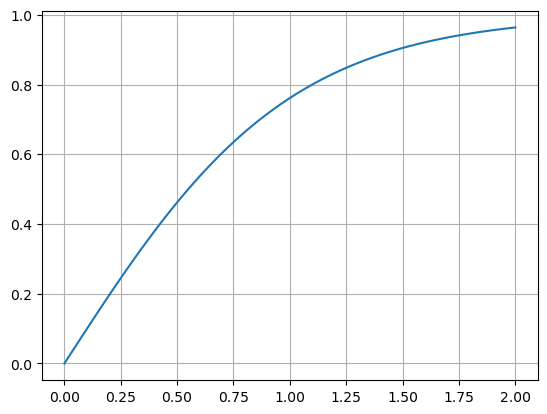

In [14]:
from reservoir.activation_functions import tanh, heaviside, sigmoid, softplus, heaviside

# the activation function choosen for the rest of the experiment
# activation_function = lambda x : sigmoid(2*(x-0.5))tanh(x)
activation_function = lambda x : tanh(x)

x=np.linspace(0, 2, 100)
plt.plot(x, activation_function(x))
plt.grid()

**common_size** : the number of different dimensions in the input data

**K** : the number of neurons that will receive a particular time serie as input 

In [15]:
import math 

RESERVOIR_SIZE = 500

# We want the size of the reservoir to be at least RESERVOIR_SIZE
K = math.ceil(RESERVOIR_SIZE / common_size)
n = common_size * K
print("Dimension of our reservoir :", n)
print("Copy of each time serie :", K)
print("Number of multivariate inputs :", common_size)

Dimension of our reservoir : 500
Copy of each time serie : 25
Number of multivariate inputs : 20


### Hyperparameters

#### Customs

#### Optuna's bests

In [16]:
import optuna
from performances.utility import retrieve_best_model

function_name = "hadsp"  # "desp" ou "hadsp" or "random"
study = retrieve_best_model(function_name, dataset_name, is_multivariate, variate_type = "multi", data_type = "normal")

# Print the best hyperparameters
print("Best hyperparameters: ")
for param_name, param_value in study.best_trial.params.items():
    globals()[param_name] = param_value
    print(param_name, param_value)

if not is_instances_classification:
    use_full_instance = None

if function_name in ["hadsp", "desp"]:
    max_increment_span = int(max_window_size) if int(max_window_size) - 100 < 0 else int(max_window_size) - 100
    MAX_TIME_INCREMENT = time_increment + time_increment_span #int(max_window_size) or None or TIME_INCREMENT


/opt/homebrew/Caskroom/miniforge/base/envs/hadsp_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Best hyperparameters: 
input_scaling 0.2
bias_scaling 0.075
leaky_rate 1.0
input_connectivity 1.0
network_size 500
ridge -5
target_rate 0.56
rate_spread 0.39
method pearson
connectivity 0.0
weight_increment 0.05
max_partners 10
use_full_instance True
time_increment 64
time_increment_span 104


## Function to initialise and generate reservoir


In [17]:
from reservoir.reservoir import init_matrices
from connexion_generation.hag import run_algorithm
from scipy import sparse
target_rate = 0.7
rate_spread = 0.1

def initialise_and_run(input_scaling, n, input_connectivity, connectivity, K, bias_scaling, seed, training_set):
    
    Win, W, bias = init_matrices(n, input_connectivity, connectivity,  K, seed=seed)
    bias *= bias_scaling
    Win *= input_scaling

    if function_name == "hadsp":
        W, (state_history, delta_z_history, W_history) = run_algorithm(W, Win, bias, leaky_rate, activation_function, training_set, time_increment, weight_increment,
                                target_rate, rate_spread, function_name, is_instance=is_instances_classification, use_full_instance = use_full_instance, 
                                max_increment=MAX_TIME_INCREMENT, max_partners=max_partners, method = "pearson", 
                                n_jobs = 12, visualize=False, record_history=True)

    elif function_name == "desp":
        W, (state_history, delta_z_history, W_history) = run_algorithm(W, Win, bias, leaky_rate, activation_function, training_set, time_increment, weight_increment,
                            min_variance, variance_spread, function_name, is_instance=is_instances_classification, use_full_instance = use_full_instance, 
                            max_increment=MAX_TIME_INCREMENT, max_partners=max_partners, method = "pearson", 
                            intrinsic_saturation=intrinsic_saturation, intrinsic_coef=intrinsic_coef, n_jobs = 12, visualize=False, record_history=True)
    else:
        raise ValueError(f"Invalid function_name: {function_name}, should be 'hadsp' or 'desp'")
    connectivity =  np.count_nonzero(W) / (W.shape[0] * W.shape[1])
    eigen = sparse.linalg.eigs(W, k=1, which="LM", maxiter=W.shape[0] * 20, tol=0.1, return_eigenvectors=False)
    sr = np.max(np.abs(eigen))

    
    
    return Win, W, bias, connectivity, sr, state_history, delta_z_history, W_history


## Multivariate case

hadsp pearson algorithm: 100%|██████████████████████████████████████████████| 497/497 [00:11<00:00, 42.28it/s]


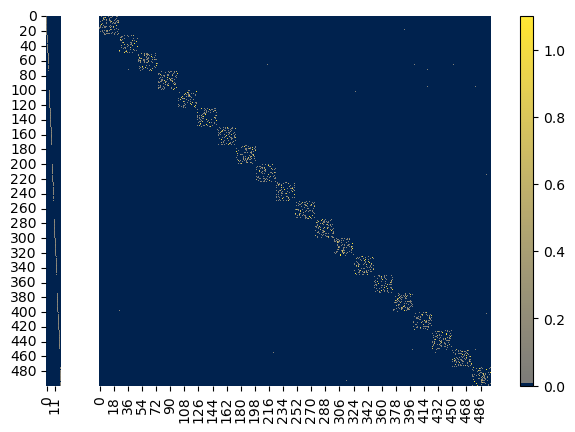

In [18]:
(Win_hag_multi, 
 W_hag_multi, 
 bias_hag_multi, 
 connectivity_band, 
 sr_hag_multi, 
 state_history_hag,
 delta_z_history,
 W_history) = initialise_and_run(input_scaling, n, input_connectivity, connectivity, K, bias_scaling, SEED, X_pretrain_band)


from matplotlib.colors import ListedColormap

custom_colormap = ListedColormap(np.vstack((plt.cm.cividis(0.0), plt.cm.cividis(np.linspace(0.5, 1, 128)))))
vmin = 0
vmax = max(np.max(Win_hag_multi), np.max(W_hag_multi))
fig, axs = plt.subplots(ncols=3, gridspec_kw=dict(width_ratios=[0.5,6,0.2]))
heatmap(Win_hag_multi, cmap=custom_colormap, cbar=False, square=True, ax=axs[0], vmin=vmin, vmax=vmax)
heatmap(W_hag_multi, cmap=custom_colormap, yticklabels=False, cbar=False, ax=axs[1], vmin=vmin, vmax=vmax)
fig.colorbar(axs[1].collections[0], cax=axs[2])

#### Algorithm Dynamics

Dynamics


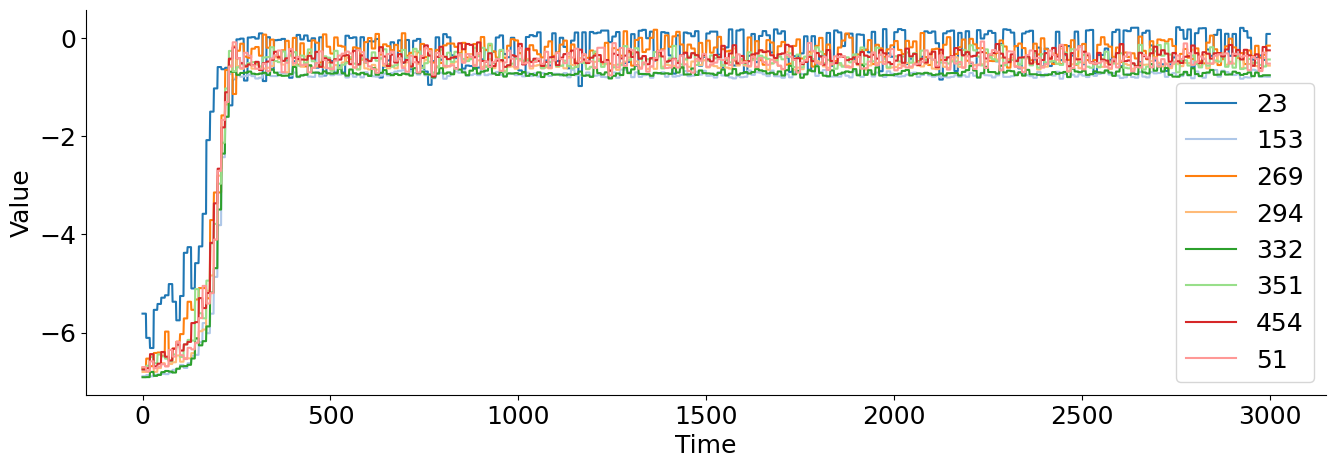

In [19]:
if delta_z_history is not None:
    fig, ax = plt.subplots(figsize=(16, 5))
    print(f'Dynamics')
    
    # NEURON ACTIVITY PLOT
    random_neurons_indices =  np.sort(np.random.randint(RESERVOIR_SIZE, size=7)) #Size max is 19 because there is not enough colors
    random_neurons_indices = np.append(random_neurons_indices, 51)
    colors = color_palette("tab20")
    # NUMBER_OF_STEP_TO_WATCH
    WATCH_FROM = 0
    WATCH_TO = 3000
    neurons_evolution = np.array(delta_z_history)[WATCH_FROM:WATCH_TO]
    x =range(len(delta_z_history))[WATCH_FROM:WATCH_TO]
    j = 0
    for i in random_neurons_indices:
        ax.plot(x, neurons_evolution[: ,i], label=str(i), color=colors[j])
        j += 1
    fontsize=18
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', labelsize=fontsize)
    plt.xlabel('Time', size=fontsize)
    plt.ylabel('Value', size=fontsize)
    plt.legend(fontsize=fontsize)


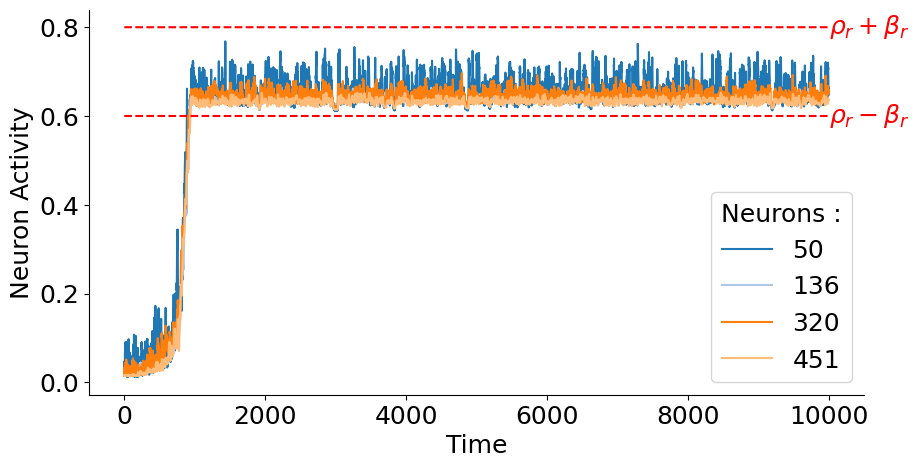

In [25]:
fig, ax = plt.subplots(figsize=(10, 5))
function_name = "hadsp"
# NEURON ACTIVITY PLOT 
random_neurons_indices =  np.sort(np.random.randint(RESERVOIR_SIZE, size=4)) #Size max is 19 because there is not enough colors
colors = color_palette("tab20")
# NUMBER_OF_STEP_TO_WATCH 
WATCH_FROM = 0
WATCH_TO = 10000
neurons_evolution = np.array(state_history_hag)[WATCH_FROM:WATCH_TO]
x =range(len(state_history_hag))[WATCH_FROM:WATCH_TO]
j = 0
for i in random_neurons_indices:
    ax.plot(x, neurons_evolution[: ,i], label=str(i), color=colors[j])
    j += 1
if function_name == "hadsp":
    ax.plot(x, np.ones(len(x))*(target_rate-rate_spread), color="red", linestyle = "--")
    ax.plot(x, np.ones(len(x))*(target_rate+rate_spread), color="red", linestyle = "--")
    ax.text(WATCH_TO, target_rate - rate_spread, r'$\rho_r - \beta_r$', color='red', fontsize=fontsize, va='center', ha='left')
    ax.text(WATCH_TO, target_rate + rate_spread, r'$\rho_r + \beta_r$', color='red', fontsize=fontsize, va='center', ha='left')

# target_rate, rate_spread
fontsize=18
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', labelsize=fontsize)
plt.xlabel('Time', size=fontsize)
plt.ylabel('Neuron Activity', size=fontsize)
plt.legend(title="Neurons :",fontsize=fontsize, title_fontsize=fontsize)

## Random matrice

In [21]:
from reservoir.reservoir import init_matrices
from scipy import sparse

# To set particular values
function_name = "random"  # "desp" ou "hadsp" or "random"
study = retrieve_best_model(function_name, dataset_name, is_multivariate, variate_type = "multi", data_type = "normal")

# Print the best hyperparameters
print("Best hyperparameters: ")
random_esn = {}
for param_name, param_value in study.best_trial.params.items():
    random_esn[param_name] = param_value
    print(param_name, param_value)

if not is_instances_classification:
    use_full_instance = None


Win_random_multi, W_random_multi, bias_random_multi = init_matrices(n, 1, random_esn["connectivity"], K, seed=19823)
bias_random_multi= bias_random_multi*random_esn['bias_scaling']
Win_random_multi= Win_random_multi*random_esn['input_scaling']


eigen_random_multi = sparse.linalg.eigs(W_random_multi, k=1, which="LM", maxiter=W_random_multi.shape[0] * 20, tol=0.1, return_eigenvectors=False)
sr_random_multi = np.max(np.abs(eigen_random_multi))


Best hyperparameters: 
input_scaling 0.09
bias_scaling 0.09
leaky_rate 1.0
input_connectivity 1.0
network_size 500
ridge -13
connectivity 0.006541055290859677
spectral_radius 0.66


# Richness

## Pearson

In [ ]:
from analysis.richness import pearson
num_windows = 150

In [ ]:
mean_correlations_hag, std_correlations_hag = pearson(state_history_hag, num_windows=num_windows)

In [ ]:
from reservoir.reservoir import update_reservoir

states_history_multi = []
neurons_state = np.random.uniform(0, 1, bias_hag_multi.size)
inputs = np.concatenate(X_pretrain_band, axis=0) if is_instances_classification else X_pretrain_band
for input_value in inputs:
    neurons_state = update_reservoir(W_hag_multi, Win_hag_multi, input_value, neurons_state, leaky_rate, bias_hag_multi, activation_function)
    states_history_multi.append(neurons_state)

mean_correlations_multi, std_correlations_multi = pearson(states_history_multi, num_windows=num_windows)

In [ ]:

# Plotting the mean correlations with the standard deviation area
fig, ax = plt.subplots(figsize=(10, 5))

time_windows = range(num_windows)
plt.plot(time_windows, mean_correlations_multi, marker='.', linestyle='-', color='b',  label="with same input after training")
plt.fill_between(time_windows, np.array(mean_correlations_multi) - np.array(std_correlations_multi),
                 np.array(mean_correlations_multi) + np.array(std_correlations_multi), color='blue', alpha=0.2)

plt.plot(time_windows, mean_correlations_hag, marker='.', linestyle='-', color='red', label="during training")
plt.fill_between(time_windows, np.array(mean_correlations_hag) - np.array(std_correlations_hag),
                 np.array(mean_correlations_hag) + np.array(std_correlations_hag), color='red', alpha=0.2)
plt.ylim(0, 1)
fontsize=18
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', labelsize=fontsize)
plt.xlabel('Steps', size=fontsize)
plt.ylabel('Average Correlation', size=fontsize)
plt.legend(fontsize=fontsize)
plt.legend(fontsize=fontsize)

plt.grid(True)

In [ ]:
from reservoir.reservoir import update_reservoir

states_history_random = []
neurons_state = np.random.uniform(0, 1, bias_random_multi.size)
inputs = np.concatenate(X_pretrain_band, axis=0) if is_instances_classification else np.array(X_pretrain_band)
for input_value in inputs:
    neurons_state = update_reservoir(W_random_multi, Win_random_multi, input_value, neurons_state, leaky_rate, bias_random_multi, activation_function)
    states_history_random.append(neurons_state)

mean_correlations_random, std_correlations_random = pearson(np.array(states_history_random), num_windows=num_windows)


# Plotting the mean correlations with the standard deviation area
fig, ax = plt.subplots(figsize=(10, 5))

time_windows = range(num_windows)
plt.plot(time_windows, mean_correlations_random, marker='.', linestyle='-', color='g',  label="with same input for random matrice")
plt.fill_between(time_windows, np.array(mean_correlations_random) - np.array(std_correlations_random),
                 np.array(mean_correlations_random) + np.array(std_correlations_random), color='g', alpha=0.2)
plt.ylim(0, 1)
fontsize=18
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', labelsize=fontsize)
plt.xlabel('Steps', size=fontsize)
plt.ylabel('Average Correlation', size=fontsize)
plt.legend(fontsize=fontsize)
plt.legend(fontsize=fontsize)

plt.grid(True)

In [ ]:

mean_correlations_random, std_correlations_random = pearson(inputs, num_windows=num_windows)


# Plotting the mean correlations with the standard deviation area
fig, ax = plt.subplots(figsize=(10, 5))

time_windows = range(num_windows)
plt.plot(time_windows, mean_correlations_random, marker='.', linestyle='-', color='y',  label="inputs correlation")
plt.fill_between(time_windows, np.array(mean_correlations_random) - np.array(std_correlations_random),
                 np.array(mean_correlations_random) + np.array(std_correlations_random), color='y', alpha=0.2)
plt.ylim(0, 1)
fontsize=18
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', labelsize=fontsize)
plt.xlabel('Steps', size=fontsize)
plt.ylabel('Average Correlation', size=fontsize)
plt.legend(fontsize=fontsize)
plt.legend(fontsize=fontsize)

plt.grid(True)

## IPC

## Cumulative explained variance
Or squared_uncoupled_dynamics


In [ ]:
import analysis.richness
reload(analysis.richness)
from analysis.richness import squared_uncoupled_dynamics, squared_uncoupled_dynamics_alternative

uds_hag = squared_uncoupled_dynamics_alternative(np.array(state_history_hag), size_window=500, num_windows=num_windows, A=0.99)
uds_multi = squared_uncoupled_dynamics_alternative(np.array(states_history_multi), size_window=500, num_windows=num_windows, A=0.99)

max_value = np.max([np.max(uds_hag), np.max(uds_hag)])

# Plotting the mean correlations with the standard deviation area
fig, ax = plt.subplots(figsize=(10, 5))

time_windows = range(len(uds_hag))
plt.plot(range(len(uds_hag)), uds_hag, marker='.', linestyle='-', color='r',  label="during training")
plt.plot(range(len(uds_multi)), uds_multi, marker='.', linestyle='-', color='b',  label="with same input after training")
plt.ylim(0, max_value)
fontsize=18
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', labelsize=fontsize)
plt.xlabel('Steps', size=fontsize)
plt.ylabel('CEV', size=fontsize)
plt.legend(fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.grid(True)

In [ ]:
import analysis.richness
reload(analysis.richness)
from analysis.richness import squared_uncoupled_dynamics

uds_random = squared_uncoupled_dynamics_alternative(np.array(states_history_random), size_window=500, num_windows=num_windows, A=0.99)

# Plotting the mean correlations with the standard deviation area
fig, ax = plt.subplots(figsize=(10, 5))

plt.plot(range(len(uds_random)), uds_random, marker='.', linestyle='-', color='g',  label="with same input for random matrice")

fontsize=18
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', labelsize=fontsize)
plt.xlabel('Steps', size=fontsize)
plt.ylabel('CEV', size=fontsize)
plt.legend(fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.grid(True)

## Linear uncoupled dynamics

In [ ]:
import analysis.richness
reload(analysis.richness)
from analysis.richness import linear_uncoupled_dynamics
num_windows = 150

LUDs_hag = linear_uncoupled_dynamics(np.array(state_history_hag), size_window=500, num_windows=num_windows, theta=0.9)
LUDs_multi = linear_uncoupled_dynamics(np.array(states_history_multi), size_window=500, num_windows=num_windows, theta=0.9)

max_value = np.max([np.max(LUDs_hag), np.max(LUDs_multi)])

# Plotting the mean correlations with the standard deviation area
fig, ax = plt.subplots(figsize=(10, 5))

time_windows = range(len(LUDs_hag))
plt.plot(range(len(uds_hag)), LUDs_hag, marker='.', linestyle='-', color='r',  label="during training")
plt.plot(range(len(LUDs_multi)), LUDs_multi, marker='.', linestyle='-', color='b',  label="with same input after training")
plt.ylim(0, max_value)
fontsize=18
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', labelsize=fontsize)
plt.xlabel('Steps', size=fontsize)
plt.ylabel('Linear Uncoupled Dynamics', size=fontsize)
plt.legend(fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.grid(True)

In [ ]:
import analysis.richness
reload(analysis.richness)
from analysis.richness import linear_uncoupled_dynamics

LUDs_random = linear_uncoupled_dynamics(np.array(states_history_random), size_window=500, num_windows=num_windows, theta=0.9)

# Plotting the mean correlations with the standard deviation area
fig, ax = plt.subplots(figsize=(10, 5))

time_windows = range(len(LUDs_random))
plt.plot(time_windows, LUDs_random, marker='.', linestyle='-', color='g',  label="with same input for random matrice")
fontsize=18
max_value = np.max([np.max(LUDs_random)])
plt.ylim(0, max_value)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', labelsize=fontsize)
plt.xlabel('Steps', size=fontsize)
plt.ylabel('Linear Uncoupled Dynamics', size=fontsize)
plt.legend(fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.grid(True)

## Condition number

In [ ]:
import analysis.richness
reload(analysis.richness)
from analysis.richness import condition_number
num_windows = 150

CNs_hag = condition_number(np.array(state_history_hag), size_window=500, num_windows=num_windows)
CNs_multi = condition_number(np.array(states_history_multi), size_window=500, num_windows=num_windows)

max_value = np.max([np.max(CNs_hag), np.max(CNs_hag)])
min_value = np.min([np.min(CNs_hag), np.min(CNs_hag)])

# Plotting the mean correlations with the standard deviation area
fig, ax = plt.subplots(figsize=(10, 5))

time_windows = range(len(CNs_hag))
plt.plot(range(len(uds_hag)), CNs_hag, marker='.', linestyle='-', color='r',  label="during training")
plt.plot(range(len(uds_multi)), CNs_multi, marker='.', linestyle='-', color='b',  label="with same input after training")
plt.ylim(min_value, max_value)
fontsize=18

ax.set_yscale('log')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', labelsize=fontsize)
plt.xlabel('Steps', size=fontsize)
plt.ylabel('Condition Numbers', size=fontsize)
plt.legend(fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.grid(True)

In [ ]:
import analysis.richness
reload(analysis.richness)
from analysis.richness import condition_number

CNs_random = condition_number(np.array(states_history_random), size_window=500, num_windows=num_windows)

# Plotting the mean correlations with the standard deviation area
fig, ax = plt.subplots(figsize=(10, 5))

time_windows = range(len(CNs_random))
plt.plot(time_windows, CNs_random, marker='.', linestyle='-', color='g',  label="with same input for random matrice")
fontsize=18
max_value = np.max([np.max(CNs_random)])
min_value = np.min([np.min(CNs_random)])

plt.ylim(min_value, max_value)
ax.set_yscale('log')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', labelsize=fontsize)
plt.xlabel('Steps', size=fontsize)
plt.ylabel('Linear Uncoupled Dynamics', size=fontsize)
plt.legend(fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.grid(True)

## Univariate case

# Performance

In [ ]:
from joblib import Parallel, delayed
from sklearn.metrics import mutual_info_score

N_JOBS = -1
RIDGE_COEF= 1e-9 if ridge is None else 10**ridge

In [ ]:
from performances.esn_model_evaluation import init_nvar_model, init_reservoir_model, init_ip_reservoir_model

reservoir_hag_multi, readout_hag_multi = init_reservoir_model(W_hag_multi, Win_hag_multi, bias_hag_multi, leaky_rate, activation_function, ridge_coef=RIDGE_COEF)
reservoir_random_multi, readout_random_multi = init_reservoir_model(W_random_multi, Win_random_multi, bias_random_multi, leaky_rate, activation_function, ridge_coef=RIDGE_COEF)

if False: # TODO: change condition for when we want to plot univariate data
    reservoir_hag_uni, readout_hag_uni  = init_reservoir_model(W_hag_uni, Win_hag_uni, bias_hag_uni, leaky_rate, activation_function, ridge_coef=RIDGE_COEF)
    reservoir_random_uni, readout_random_uni = init_reservoir_model(W_random_uni, Win_random_uni, bias_random_uni, leaky_rate, activation_function, ridge_coef=RIDGE_COEF)


## Classification

In [ ]:
if not is_instances_classification:
    raise ValueError("This is not the right Classification section.")

### Classification for multivariate

In [ ]:
print("X_train_band_duplicated example shape :", X_train_band[1].shape)     
print("We should have :", X_train_band[0].shape[1], "==", common_size)

In [ ]:
from performances.esn_model_evaluation import train_model_for_classification, predict_model_for_classification, compute_score
# To remember : 
#  For reservoirpy   pre_s = W @ r + Win @ (u + noise_gen(dist=dist, shape=u.shape, gain=g_in)) + bias

train_data_multi = X_train_band # X_train_band_noisy or X_train_band
Y_data = Y_val if use_cross_validation else Y_test

mode="sequence-to-vector"
train_model_for_classification(reservoir_hag_multi, readout_hag_multi, train_data_multi, Y_train, n_jobs = N_JOBS, mode=mode)
train_model_for_classification(reservoir_random_multi, readout_random_multi, train_data_multi, Y_train, N_JOBS, mode=mode)


#### noisy 

In [ ]:
from performances.esn_model_evaluation import predict_model_for_classification, compute_score

test_data_multi_noisy = X_test_band_noisy # X_test_band_noisy or X_test_band

Y_pred_hag_multi = predict_model_for_classification(reservoir_hag_multi, readout_hag_multi, test_data_multi_noisy, N_JOBS)
score = compute_score(Y_pred_hag_multi, Y_data, is_instances_classification, function_name + " multi", verbosity=1)

Y_pred_random_multi = predict_model_for_classification(reservoir_random_multi, readout_random_multi, test_data_multi_noisy, N_JOBS)
score = compute_score(Y_pred_random_multi, Y_data, is_instances_classification, "random multi", verbosity=1)

#### normal

In [ ]:

test_data_multi = X_test_band # X_test_band_noisy or X_test_band

Y_pred_hag_multi = predict_model_for_classification(reservoir_hag_multi, readout_hag_multi, test_data_multi, -1)
score = compute_score(Y_pred_hag_multi, Y_data, is_instances_classification, function_name + " multi", verbosity=1)

Y_pred_random_multi = predict_model_for_classification(reservoir_random_multi, readout_random_multi, test_data_multi, N_JOBS)
score = compute_score(Y_pred_random_multi, Y_data, is_instances_classification, "random multi", verbosity=1)

### Classification for univariate

In [ ]:
if False:  # TODO: change condition for when we want to plot univariate data
    # Create a list to store the arrays with the same shape as the expected input of the reservoir

    train_data_uni = [ts.reshape(-1, 1) for ts in X_train]
    test_data_uni = [ts.reshape(-1, 1) for ts in X_test]

    print("number of instances in train_data_uni :", len(train_data_uni), "should be equal to", len(X_train))     
    print("example of train_data_uni train shape :", train_data_uni[0].shape)     
    print("We should have :", train_data_uni[0].shape[1], "==", 1)

In [ ]:
if False: # TODO: change condition for when we want to plot univariate data
    reservoir_hag_uni, readout_hag_uni = train_model_for_classification(W_hag_uni, Win_hag_uni, bias_hag_uni, leaky_rate, activation_function, train_data_uni, Y_train, N_JOBS, RIDGE_COEF, mode="sequence-to-vector")

    reservoir_random_uni, readout_random_uni = train_model_for_classification(W_normal, Win_normal, bias_normal, leaky_rate, activation_function, train_data_uni, Y_train, N_JOBS, RIDGE_COEF, mode="sequence-to-vector")

In [ ]:
if False: # TODO: change condition for when we want to plot univariate data
    Y_pred_hag_uni = predict_model_for_classification(reservoir_hag_uni, readout_hag_uni, test_data_uni, N_JOBS)
    score = compute_score(Y_pred_hag_uni, Y_test, is_instances_classification, function_name + " uni", verbosity=1)
    
    Y_pred_normal = predict_model_for_classification(reservoir_random_uni, readout_random_uni, test_data_uni, N_JOBS)
    score = compute_score(Y_pred_normal, Y_test, is_instances_classification, "random uni", verbosity=1)

## Prediction ahead

In [ ]:
if is_instances_classification:
    raise ValueError("This is not the right Classification section.")

### Plot datasets
Noisy or normal dataset can be ploted

In [ ]:
# Concatenate train and test arrays for plotting
combined_data = np.concatenate((X_train_band, X_val_band), axis=0)

# noisy version
combined_data_noisy = np.concatenate((X_train_band, X_val_band_noisy), axis=0)
combined_Y =np.concatenate((Y_train, Y_val), axis=0)

# Calculate the merge point index
merge_point_index = X_train_band.shape[0]

# Define the range around the merge point to plot
start_index = merge_point_index - 100
end_index = merge_point_index + 100

# Plot for a subset N features within a range arround transition from train to test
N = 3
plt.figure(figsize=(16, 5))
for i in [1, 13, 17]: 
    plt.plot(range(start_index, end_index), combined_data_noisy[start_index:end_index, i], label=f'Feature {i}')
plt.plot(range(start_index, end_index), combined_Y[start_index:end_index], label="Prediction")
plt.title('Feature Values Around Merge Point')
plt.xlabel('Sample Index')
plt.ylabel('Feature Value')
plt.legend()
plt.show()

### Training
Noisy or normal dataset can be used

In [ ]:
from performances.esn_model_evaluation import train_model_for_prediction, compute_score
from performances.esn_model_evaluation import init_nvar_model, init_reservoir_model, init_ip_reservoir_model

if not is_multivariate:
    train_data_uni = X_train # X_train_noisy or X_train
    
    # Training random + MG
    esn_random_uni = train_model_for_prediction(reservoir, readout, train_data_uni, Y_train, RIDGE_COEF)
    
    # Training for hag + MG
    esn_hag_uni = train_model_for_prediction(reservoir, readout, train_data_uni, Y_train, RIDGE_COEF)

    
train_data_multi = X_train_band # X_train_band_noisy or train_band_inputs

# Training random + bandfilter
esn_random_multi = train_model_for_prediction(reservoir, readout, bias_random_multi, leaky_rate, activation_function, train_data_multi, Y_train, RIDGE_COEF)

# Training output HASDP + bandfilter
esn_hag_multi = train_model_for_prediction(reservoir, readout, leaky_rate, activation_function, train_data_multi, Y_train, RIDGE_COEF)
                                                       

### Prediction
Noisy or normal dataset can be used

In [ ]:
if not is_multivariate:
    test_data_uni = X_val # X_val_noisy or X_val

    # Prediction for random + MG
    y_pred_random_uni = esn_random_uni.run(test_data_uni, reset=False) 

    # Prediction for hag + MG
    y_pred_hag_uni = esn_hag_uni.run(test_data_uni, reset=False) 


test_data_multi = X_val_band # X_test_band_noisy_duplicated or X_test_band_duplicated

# Prediction for random + bandfilter
y_pred_random_multi = esn_random_multi.run(test_data_multi, reset=False)

# Prediction for hag + bandfilter
y_pred_hag_multi = esn_hag_multi.run(test_data_multi, reset=False)


In [ ]:
from plots.plots import plot_results
from performances.esn_model_evaluation import compute_score

START_STEP = 30
END_STEP = 500
slice_range = slice(START_STEP, END_STEP)

if not is_multivariate:
    print("nrmse normal         :", compute_score(Y_val[slice_range], y_pred_random_uni[slice_range], is_instances_classification))
    print("nrmse hag          :", compute_score(Y_val[slice_range], y_pred_hag_uni[slice_range], is_instances_classification))

print("nrmse random + band  :", compute_score(Y_val[slice_range], y_pred_random_multi[slice_range], is_instances_classification))
print("nrmse hag + band   :", compute_score(Y_val[slice_range], y_pred_hag_multi[slice_range], is_instances_classification))

plot_results(y_pred_hag_multi, Y_test, 0, 300)


In [ ]:
if not is_multivariate:
    test_data_uni = X_val_noisy # X_val_noisy or X_val

    # Prediction for random + MG
    y_pred_random_uni = esn_random_uni.run(test_data_uni, reset=False) 

    # Prediction for hag + MG
    y_pred_hag_uni = esn_hag_uni.run(test_data_uni, reset=False) 

test_data_multi = X_val_band_noisy # X_test_band_noisy_duplicated or X_test_band_duplicated

# Prediction for random + bandfilter
y_pred_random_multi = esn_random_multi.run(test_data_multi, reset=False)

# Prediction for hag + bandfilter
y_pred_hag_multi = esn_hag_multi.run(test_data_multi, reset=False)


In [ ]:
from plots.plots import plot_results

START_STEP = 30
END_STEP = 500
slice_range = slice(START_STEP, END_STEP)

if not is_multivariate:
    print("nrmse normal         :", compute_score(y_pred_random_uni[slice_range], Y_val[slice_range], is_instances_classification))
    print("nrmse hag          :", compute_score(y_pred_hag_uni[slice_range], Y_val[slice_range], is_instances_classification))
print("nrmse random + band  :", compute_score(y_pred_random_multi[slice_range], Y_val[slice_range], is_instances_classification))
print("nrmse hag + band   :", compute_score(y_pred_hag_multi[slice_range], Y_val[slice_range], is_instances_classification))

plot_results(y_pred_hag_multi, Y_test, 0, 300)


#### Moving average 

In [ ]:
from performances.esn_model_evaluation import compute_score

# moving average of the y
span=7
pad_width = span // 2

if not is_multivariate:
    ave_y_random_uni = np.convolve(np.pad(y_pred_random_uni.flatten(), pad_width, mode='edge'), np.ones(span), 'valid') / span
    ave_y_hag_uni = np.convolve(np.pad(y_pred_hag_uni.flatten(), pad_width, mode='edge') , np.ones(span), 'valid') / span
ave_y_random_multi = np.convolve(np.pad(y_pred_random_multi.flatten(), pad_width, mode='edge'), np.ones(span), 'valid') / span
ave_y_hag_multi = np.convolve(np.pad(y_pred_hag_multi.flatten(), pad_width, mode='edge'), np.ones(span), 'valid') / span

if not is_multivariate:
    print("nrmse normal         :", compute_score(ave_y_random_uni[slice_range], Y_val[slice_range], is_instances_classification))
    print("nrmse hag          :", compute_score(ave_y_hag_uni[slice_range], Y_val[slice_range], is_instances_classification))
print("nrmse random + band  :", compute_score(ave_y_random_multi[slice_range], Y_val[slice_range], is_instances_classification))
print("nrmse hag + band   :", compute_score(ave_y_hag_multi[slice_range], Y_val[slice_range], is_instances_classification))
 
plot_results(ave_y_hag_multi.reshape(-1,1), Y_test, 300)

In [ ]:
nrmse_array_random_uni = []
nrmse_array_hag_uni = []
nrmse_array_random_multi = []
nrmse_array_hag_multi = []

for i in range(len(Y_val)-100- step_ahead):
    Y_val_i = Y_val[i:100+i]
    nrmse_array_random_uni.append(compute_score(Y_val_i, y_pred_random_uni[i:100+i], is_instances_classification))
    nrmse_array_hag_uni.append(compute_score(Y_val_i, y_pred_hag_uni[i:100+i], is_instances_classification))
    nrmse_array_random_multi.append(compute_score(Y_val_i, y_pred_random_multi[i:100+i], is_instances_classification))
    nrmse_array_hag_multi.append(compute_score(Y_val_i, y_pred_hag_multi[i:100+i], is_instances_classification))
    
log10_nrmse_random_uni= np.log10(nrmse_array_random_uni)
log10_nrmse_hag_uni = np.log10(nrmse_array_hag_uni)
log10_nrmse_random_multi = np.log10(nrmse_array_random_multi)
log10_nrmse_hag_multi = np.log10(nrmse_array_hag_multi)
plt.figure()
plt.plot(log10_nrmse_random_uni[:1000])
plt.plot(log10_nrmse_hag_uni[:1000])
plt.plot(log10_nrmse_random_multi[:1000])
plt.plot(log10_nrmse_hag_multi[:1000])

plt.xlabel('Time steps')
plt.ylabel('Log10 NRMSE')
plt.legend(["hag+band", "random", " random + bandfilter", "hag"])
plt.show()

# Analysis

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import linkage, leaves_list

scaler = MinMaxScaler(feature_range=(-1, 1))

# pretrain
# Be really carefull of the column order here !
df_data = scaler.fit_transform(X_pretrain_band.T)
df_data = df_data.T
df = pd.DataFrame(df_data.T)
# Initialize a progress bar for total number of series
progress_bar = tqdm(total=df.shape[1]**2, position=0, leave=True)

# Initialize an empty correlation matrix
correlation_matrix = pd.DataFrame(index=df.columns, columns=df.columns)

# Calculate the correlation for each pair of series
for col1 in df.columns:
    progress_bar.set_description(f"Processing {col1}")
    for col2 in df.columns:
        correlation_matrix.loc[col1, col2] = df[col1].corr(df[col2], method='pearson', min_periods=5)

        progress_bar.update(1)  # Update the progress bar after processing each series
    
progress_bar.close()

# Convert correlation_matrix to numeric as it is stored as objects due to tqdm
correlation_matrix = correlation_matrix.apply(pd.to_numeric)

# Perform hierarchical clustering
linked = linkage(correlation_matrix, 'single')

# Get the order of rows/columns after hierarchical clustering
row_order = leaves_list(linked)

# Reorder the correlation matrix
sorted_corr_matrix = correlation_matrix.iloc[row_order, :].iloc[:, row_order]

# Visualize the sorted correlation matrix with a heatmap
plt.figure(figsize=(10,7))
sns.heatmap(sorted_corr_matrix, annot=False, cmap='vlag', vmin=-1, vmax=1)
plt.title('Clustered Pairwise Correlation of Time Series')
plt.show()


In [ ]:
from scipy.sparse import coo_matrix

row_order_r = np.array([i + k for i in row_order*K for k in range(K)])

# Convert the sparse matrix to a dense format (if memory allows)
dense_matrix = W_hag_multi.toarray()

# Reorder the dense matrix using the repeated ordering
reordered_matrix = dense_matrix[np.ix_(row_order_r, row_order_r)]

# Convert the reordered dense matrix back to a sparse format if needed
sparse_reordered_matrix = coo_matrix(reordered_matrix)

In [ ]:
heatmap(sparse_reordered_matrix.todense(), cmap=color_palette("vlag", as_cmap=True))

## Motifs

In [ ]:
import analysis.topology
reload(analysis.topology)
from analysis.topology import motif_distribution, draw_motifs_distribution

motifs_count = motif_distribution(W_hag_multi.A)
draw_motifs_distribution(motifs_count)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson, binom

def analyze_connectivity_matrix(matrix):
    # Extract weights from the matrix (ignoring the diagonal and zeros)
    weights = matrix.flatten()
    weights = weights[weights != 0]
    bin_centers, counts = np.unique(weights, return_counts=True)
    
    # Calculate the difference for all centers
    diffs = np.diff(bin_centers)
    # Add the last difference for the last bin
    diffs = np.append(diffs, diffs[-1])
    
    # Calculate the bin edges based on bin centers and differences
    bin_edges = bin_centers - diffs/2
    # Add the last bin edge
    bin_edges = np.append(bin_edges, bin_centers[-1] + diffs[-1]/2)
    
    # Plot histogram
    plt.bar(bin_centers, counts, align='center', alpha=0.6, width=np.diff(bin_centers).min())
    
    # Fit to Poisson distribution
    lambda_est = np.mean(weights)
    plt.plot(bin_centers, poisson.pmf(range(len(bin_centers)), lambda_est)*counts[0], 'r-', label='Poisson fit')
    
    # Fit to Binomial distribution using derived relations
    mean = np.mean(weights)
    variance = np.var(weights)
    
    # Calculate p and n estimates
    p_est = mean ** 2 / (n * mean - variance) if (n * mean - variance) != 0 else 0
    n_est = int(round(mean / p_est)) if p_est != 0 else 0  # n should be integer

    # Check parameter validity
    if not(0 < p_est < 1):
        print("Estimated parameters are not valid for the Binomial distribution.")
    else:
        x_vals = range(len(bin_centers))
        plt.plot(bin_centers, binom.pmf(x_vals, n_est, p_est) * counts[0], 'g-', label='Binomial fit')

    plt.legend()
    plt.show()

    return {"Poisson": lambda_est, "Binomial": (n_est, p_est)}


# Assuming W_hag_multi.A is your connectivity matrix
analyze_connectivity_matrix(W_hag_multi.A)